In [ ]:
%%capture
%pip install transformers datasets

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer
import torch
from transformers import BertForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
import os
from transformers import DistilBertForSequenceClassification
from transformers import AutoModel, AutoTokenizer
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/MyDrive/Dataset_Strategies.csv"
df = pd.read_csv(file_path)
df.head()

,Context,Response,Strategy
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb...",Gestalt Therapy
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see...",Cognitive Behavioral Therapy (CBT)
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...,Cognitive Behavioral Therapy (CBT)
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...,Psychodynamic Therapy
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...,Psychodynamic Therapy


In [ ]:
print("Column Names:", df.columns)

Column Names: Index(['Context', 'Response', 'Strategy'], dtype='object')


In [ ]:
texts = df["Response"]

label_encoder = LabelEncoder()
df["strategy_label"] = label_encoder.fit_transform(df["Strategy"])
labels = df["strategy_label"]

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=200, stratify=labels, random_state=42
)

print("Training data distribution:\n", train_labels.value_counts())
print("\nTesting data distribution:\n", test_labels.value_counts())

Training data distribution:
 strategy_label
1    834
5    556
4    508
0    497
2    468
3    445
6      4
Name: count, dtype: int64

Testing data distribution:
 strategy_label
1    50
5    34
4    31
0    30
2    28
3    27
Name: count, dtype: int64


In [ ]:
from sklearn.utils import resample

df = df[df["strategy_label"] != 6]

texts = df["Response"]
labels = df["strategy_label"]

data_df = pd.DataFrame({"text": texts, "label": labels})

max_count = data_df["label"].value_counts().max()

balanced_df = data_df.groupby("label", group_keys=False).apply(lambda x: x.sample(max_count, replace=True))

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

texts = balanced_df["text"]
labels = balanced_df["label"]

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=200, stratify=labels, random_state=42
)

print("Updated Training data distribution:\n", train_labels.value_counts())
print("\nUpdated Testing data distribution:\n", test_labels.value_counts())

Updated Training data distribution:
 label
5    851
0    851
2    851
1    851
3    850
4    850
Name: count, dtype: int64

Updated Testing data distribution:
 label
3    34
4    34
0    33
2    33
5    33
1    33
Name: count, dtype: int64


<ipython-input-8-009f6d15a4d5>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = data_df.groupby("label", group_keys=False).apply(lambda x: x.sample(max_count, replace=True))


In [ ]:
strategy_mapping = dict(zip(df["strategy_label"], df["Strategy"]))

unique_strategies = df["Strategy"].unique()

print("The six remaining therapy strategies are:\n")
for i, strategy in enumerate(unique_strategies):
    print(f"{i}: {strategy}")

The six remaining therapy strategies are:

0: Gestalt Therapy
1: Cognitive Behavioral Therapy (CBT)
2: Psychodynamic Therapy
3: Existential Therapy
4: Behavioral Therapy
5: Humanistic Therapy


### Tokenize using BERT

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(
    list(train_texts),
    truncation=True,
    padding="max_length",
    max_length=512
)

test_encodings = tokenizer(
    list(test_texts),
    truncation=True,
    padding="max_length",
    max_length=512
)


In [ ]:
class TherapyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels.iloc[idx])  # Convert labels to tensor
        return item

# Create dataset objects
train_dataset = TherapyDataset(train_encodings, train_labels)
test_dataset = TherapyDataset(test_encodings, test_labels)

print("Dataset preparation complete!")

Dataset preparation complete!


In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=6
)


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=15,
    weight_decay=0.05,
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=3,
    fp16=True,
    learning_rate=5e-5,
    warmup_ratio=0.1,
    lr_scheduler_type="linear",
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
print(tokenizer.decode(train_encodings["input_ids"][0]))

[CLS] the answer depends on what state you live. since the description you write here is that your brother may be a serious risk to himself and others, it is worth contacting a mental health hotline or one of your local area hospitals and talk to a social worker or other professional level person in their psychiatry department. ask the same question you posted here. your question is a good one and merits serious follow through. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [ ]:
from transformers import EarlyStoppingCallback

early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,  # Stop if no improvement for 3 epochs
    early_stopping_threshold=0.001
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    callbacks=[early_stopping] 
)

<ipython-input-17-6b6fc877c67d>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.792700,1.754087
2,1.581900,1.463433
3,1.149000,1.090950
4,0.879100,1.038504
5,0.733900,0.914584
6,0.640200,0.939355
7,0.586900,0.917659
8,0.530000,0.921168


TrainOutput(global_step=1280, training_loss=0.9873310983181, metrics={'train_runtime': 961.0925, 'train_samples_per_second': 79.659, 'train_steps_per_second': 2.497, 'total_flos': 1.0743736453300224e+16, 'train_loss': 0.9873310983181, 'epoch': 8.0})

In [ ]:
save_path = "/content/drive/MyDrive/saved_model"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/saved_model/tokenizer_config.json',
 '/content/drive/MyDrive/saved_model/special_tokens_map.json',
 '/content/drive/MyDrive/saved_model/vocab.txt',
 '/content/drive/MyDrive/saved_model/added_tokens.json')

In [ ]:
from transformers import AutoModelForSequenceClassification
import safetensors.torch

save_path = "/content/drive/MyDrive/saved_model"

# Load model with SafeTensors
model = AutoModelForSequenceClassification.from_pretrained(save_path, use_safetensors=True)
tokenizer = AutoTokenizer.from_pretrained(save_path)

print("Model and tokenizer loaded successfully!")

Model and tokenizer loaded successfully!


In [ ]:
def evaluate_test_subset(sample_size=200):
    test_subset_texts = test_texts[:sample_size]
    test_subset_labels = test_labels[:sample_size]

    inputs = tokenizer(list(test_subset_texts), return_tensors="pt", truncation=True, padding=True, max_length=512)

    if "token_type_ids" in inputs:
        del inputs["token_type_ids"]

    with torch.no_grad():
        logits = model(**inputs).logits

    predictions = torch.argmax(logits, dim=1).cpu().numpy()
    accuracy = accuracy_score(test_subset_labels, predictions)
    return accuracy

test_subset_accuracy = evaluate_test_subset(50)
print(f"Test Data Accuracy (First 50 Samples): {test_subset_accuracy:.4f}")


Test Data Accuracy (First 50 Samples): 0.8000


In [ ]:
def evaluate_train_subset(sample_size=3000):
    train_subset_texts = train_texts[:sample_size]
    train_subset_labels = train_labels[:sample_size]

    inputs = tokenizer(list(train_subset_texts), return_tensors="pt", truncation=True, padding=True, max_length=512)

    if "token_type_ids" in inputs:
        del inputs["token_type_ids"]

    with torch.no_grad():
        logits = model(**inputs).logits

    predictions = torch.argmax(logits, dim=1).cpu().numpy()
    accuracy = accuracy_score(train_subset_labels, predictions)
    return accuracy

train_subset_accuracy = evaluate_train_subset(50)
print(f"Train Data Accuracy (First 50 Samples): {train_subset_accuracy:.4f}")




Train Data Accuracy (First 50 Samples): 0.9000


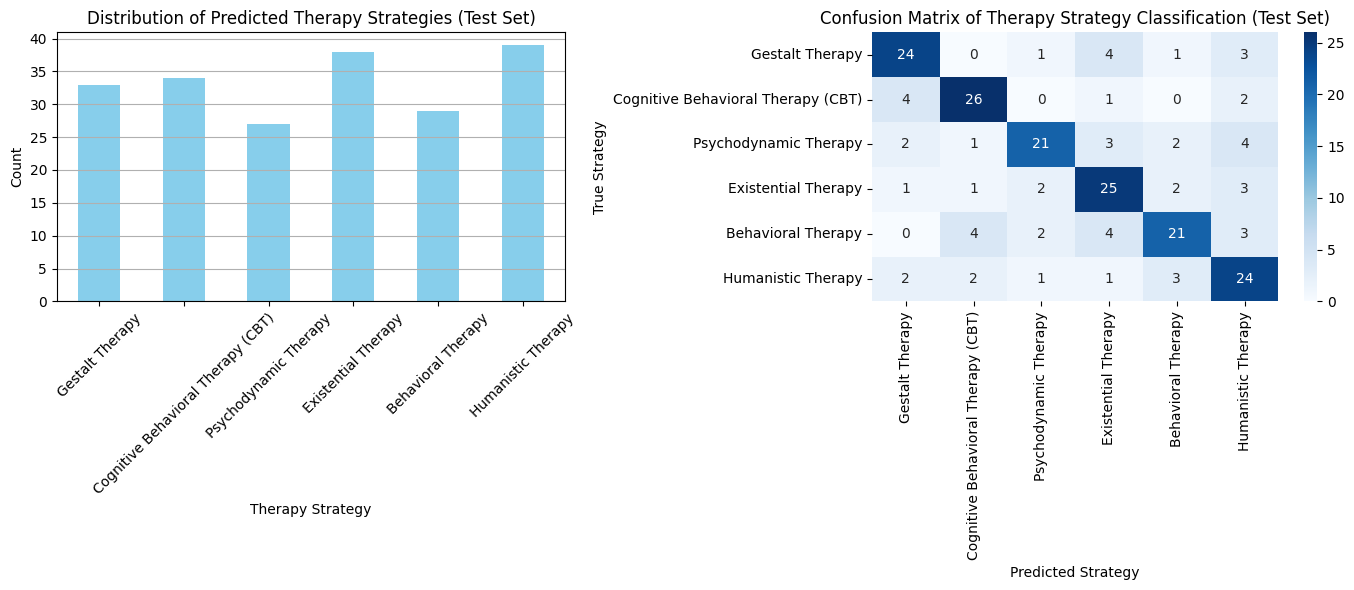

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification

model_path = "/content/drive/MyDrive/saved_model"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()  # Set model to evaluation mode

strategy_mapping = {
    0: "Gestalt Therapy",
    1: "Cognitive Behavioral Therapy (CBT)",
    2: "Psychodynamic Therapy",
    3: "Existential Therapy",
    4: "Behavioral Therapy",
    5: "Humanistic Therapy"
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

predictions = []
true_labels = []

for batch in test_dataset:
    inputs = {key: val.unsqueeze(0).to(device) for key, val in batch.items() if key != "labels"} 
    label = batch["labels"].item()  

    with torch.no_grad():
        outputs = model(**inputs)
        predicted_label = torch.argmax(outputs.logits, dim=1).item()  

    predictions.append(predicted_label)
    true_labels.append(label)

df_test = pd.DataFrame({"True_Strategy": true_labels, "Predicted_Strategy": predictions})

df_test["True_Strategy"] = df_test["True_Strategy"].map(strategy_mapping)
df_test["Predicted_Strategy"] = df_test["Predicted_Strategy"].map(strategy_mapping)

all_strategies = list(strategy_mapping.values())
strategy_counts = df_test["Predicted_Strategy"].value_counts().reindex(all_strategies, fill_value=0)

conf_matrix = confusion_matrix(df_test["True_Strategy"], df_test["Predicted_Strategy"], labels=all_strategies)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

strategy_counts.plot(kind="bar", color="skyblue", ax=axes[0])
axes[0].set_xlabel("Therapy Strategy")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Predicted Therapy Strategies (Test Set)")
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis="y")

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=all_strategies, yticklabels=all_strategies, ax=axes[1])
axes[1].set_xlabel("Predicted Strategy")
axes[1].set_ylabel("True Strategy")
axes[1].set_title("Confusion Matrix of Therapy Strategy Classification (Test Set)")

plt.tight_layout()
plt.show()


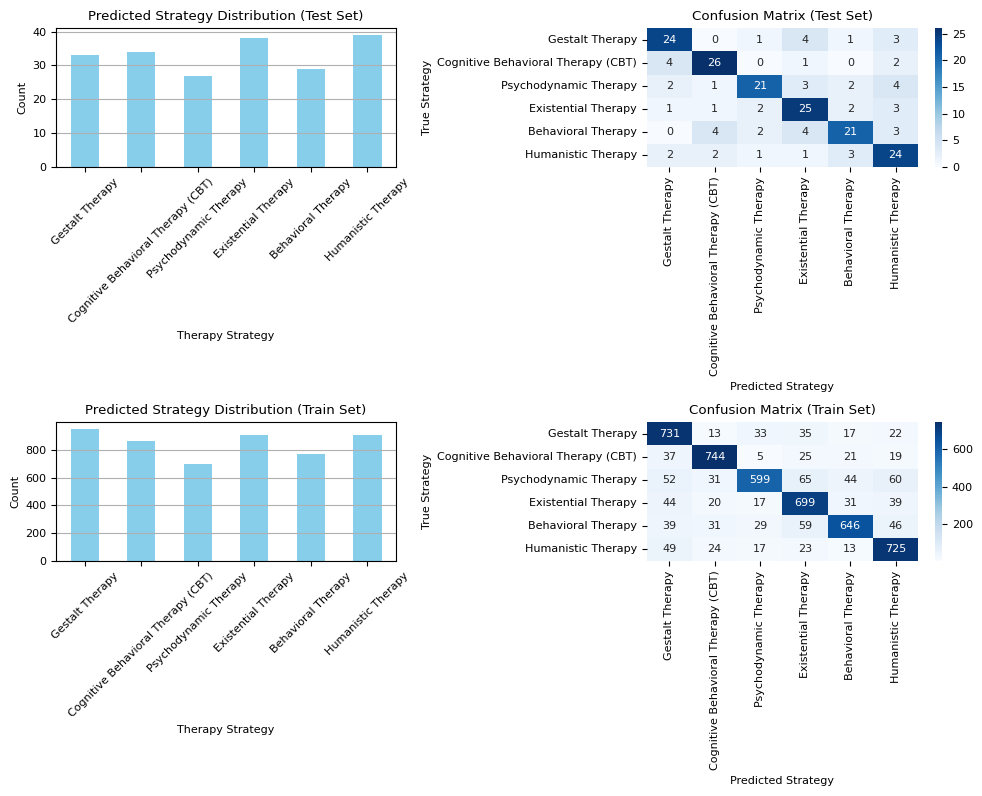

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification

model_path = "saved_model"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

strategy_mapping = {
    0: "Gestalt Therapy",
    1: "Cognitive Behavioral Therapy (CBT)",
    2: "Psychodynamic Therapy",
    3: "Existential Therapy",
    4: "Behavioral Therapy",
    5: "Humanistic Therapy"
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def predict_dataset(dataset):
    predictions, true_labels = [], []
    for batch in dataset:
        inputs = {key: val.unsqueeze(0).to(device) for key, val in batch.items() if key != "labels"}
        label = batch["labels"].item()
        with torch.no_grad():
            outputs = model(**inputs)
            predicted_label = torch.argmax(outputs.logits, dim=1).item()
        predictions.append(predicted_label)
        true_labels.append(label)
    return predictions, true_labels

test_predictions, test_true_labels = predict_dataset(test_dataset)
train_predictions, train_true_labels = predict_dataset(train_dataset)

df_test = pd.DataFrame({"True_Strategy": test_true_labels, "Predicted_Strategy": test_predictions})
df_train = pd.DataFrame({"True_Strategy": train_true_labels, "Predicted_Strategy": train_predictions})
df_test = df_test.replace(strategy_mapping)
df_train = df_train.replace(strategy_mapping)

all_strategies = list(strategy_mapping.values())
test_strategy_counts = df_test["Predicted_Strategy"].value_counts().reindex(all_strategies, fill_value=0)
train_strategy_counts = df_train["Predicted_Strategy"].value_counts().reindex(all_strategies, fill_value=0)

test_conf_matrix = confusion_matrix(df_test["True_Strategy"], df_test["Predicted_Strategy"], labels=all_strategies)
train_conf_matrix = confusion_matrix(df_train["True_Strategy"], df_train["Predicted_Strategy"], labels=all_strategies)

plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, (counts, title) in enumerate(zip([test_strategy_counts, train_strategy_counts], ["Test Set", "Train Set"])):
    counts.plot(kind="bar", color="skyblue", ax=axes[i, 0])
    axes[i, 0].set_xlabel("Therapy Strategy")
    axes[i, 0].set_ylabel("Count")
    axes[i, 0].set_title(f"Predicted Strategy Distribution ({title})")
    axes[i, 0].tick_params(axis='x', rotation=45)
    axes[i, 0].grid(axis="y")

for i, (matrix, title) in enumerate(zip([test_conf_matrix, train_conf_matrix], ["Test Set", "Train Set"])):
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=all_strategies, yticklabels=all_strategies, ax=axes[i, 1])
    axes[i, 1].set_xlabel("Predicted Strategy")
    axes[i, 1].set_ylabel("True Strategy")
    axes[i, 1].set_title(f"Confusion Matrix ({title})")

plt.tight_layout()
plt.show()